# Identifying cell types and activity programs in simulated scRNA-seq data using Linear CorEx

In this tutorial, we analyze the synthetic scRNA-seq data with known 13 cell types and 1 acivity program that in expressed across 4 cell types. First, we create an anndata object using the count matrix obtained with Splatter data simulation R package. Then we feed the normalized counts into CorEx algorithm and find latent factors. Finally, we correlate ground truth and CorEx-inferred genes' expression in each GEP. We also visualize each CorEx-inferred GEPs' expression in each cell.

In [6]:
import linearcorex as lc
import pandas as pd
import os
import codecs
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import scanpy as sc
import anndata
import seaborn as sns

### Create anndata object

This scRNA-seq data was simulated using Splatter R package. As a result of simulation, we have the following files: <br>
 count_filt: preprocessed cell by gene count matrix <br>
 geneparams: gene information including mean expression of each gene in each group <br>
 cellparams: cell info about each cell <br>
 genestats: statistics of expression for each gene

In [7]:
count_filt = pd.read_csv("data/counts_filt.csv", header = 0, index_col = 0)
geneparams = pd.read_csv("data/geneparams.csv", header = 0, index_col = 0)
cellparams = pd.read_csv("data/cellparams.csv", header = 0, index_col = 0)
genestats = pd.read_csv("data/genestats.txt", sep="\t", header = 0, index_col = 0)

Create anndata object using the count matrix

In [8]:
adata = anndata.AnnData(count_filt)

#### Process anndata object to be able to visualize it in UMAP

In [9]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers['normalized_unscaled'] = adata.X
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

In [10]:
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/Users/yuliai/opt/miniconda3/envs/py38/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yuliai/opt/miniconda3/envs/py38/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yuliai/opt/miniconda3/envs/py38/lib/python3.8/site-packag

#### Add cell information to anndata object

In [11]:
cellparams['group'] = cellparams.group.astype('category')
cellparams['has_program'] = cellparams.has_program.astype('category')

In [12]:
adata.obs['celltypes'] = cellparams.loc[:,'group']
adata.obs['has_program'] = cellparams.loc[:,'has_program']

Now we can visualize true activity (has_program) and identity (cell types) GEPs that we have simulated earlier

/Users/yuliai/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yuliai/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


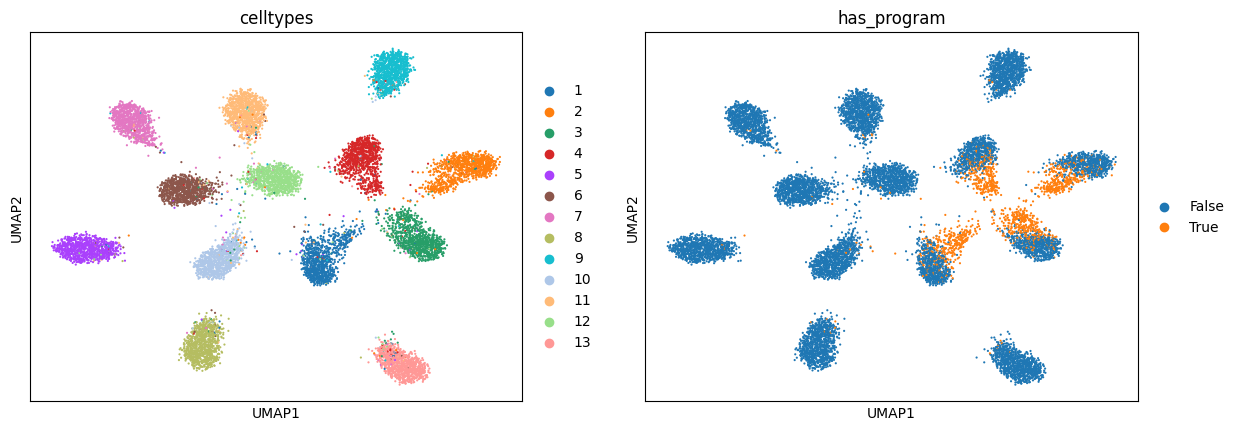

In [13]:
sc.pl.umap(adata, color = ['celltypes', 'has_program'])

As we can see from UMAP visualization above, there are 13 cell types (left) and 4 of them share some activity program (right).

### Finding identity and activity GEPs with CorEx

Next, we will see if CorEx can find those cell types and activity program.

#### Get normalized count matrix

CorEx takes normalized count matrix as an input. We have saved normalized counts in 'normalized_unscaled' layer above

In [14]:
adata_norm = pd.DataFrame(adata.layers['normalized_unscaled'], index = adata.obs_names, columns = adata.var_names)

#### Find an optimal number of GEPs

Now we need to find an optimal number of GEPs

In [15]:
def optim_n(data, nmin, nmax):
    scores = []
    for n in range(nmin, nmax):
        out = lc.Corex(n_hidden=n, gpu=False, verbose=True, gaussianize='standard', seed = 100).fit(data)
        m = out.moments
        scores.append(m["TC_no_overlap"])
    return(scores)

We know that in our ground truth we have 13 cell types and one activity program. So, we will look for an optimal number of GEPs in a range around 14. 

In [16]:
scores = optim_n(adata_norm, 10,18)

Linear CorEx with 10 latent factors
311 iterations to tol: 0.000010, TC=11.377301
35 iterations to tol: 0.000010, TC=17.813383
17 iterations to tol: 0.000010, TC=20.347719
5 iterations to tol: 0.000010, TC=21.289047
5 iterations to tol: 0.000010, TC=21.631887
4 iterations to tol: 0.000010, TC=21.755861
6 iterations to tol: 0.000010, TC=21.825719
Linear CorEx with 11 latent factors
369 iterations to tol: 0.000010, TC=12.084105
40 iterations to tol: 0.000010, TC=18.953674
16 iterations to tol: 0.000010, TC=21.661222
11 iterations to tol: 0.000010, TC=22.667324
5 iterations to tol: 0.000010, TC=23.033707
4 iterations to tol: 0.000010, TC=23.166182
3 iterations to tol: 0.000010, TC=23.240805
Linear CorEx with 12 latent factors
495 iterations to tol: 0.000010, TC=12.689491
44 iterations to tol: 0.000010, TC=19.950534
12 iterations to tol: 0.000010, TC=22.817581
15 iterations to tol: 0.000010, TC=23.883735
3 iterations to tol: 0.000010, TC=24.271981
4 iterations to tol: 0.000010, TC=24.41237

Let's visualize TC scores for each number of GEPs. We need the number with the highest score

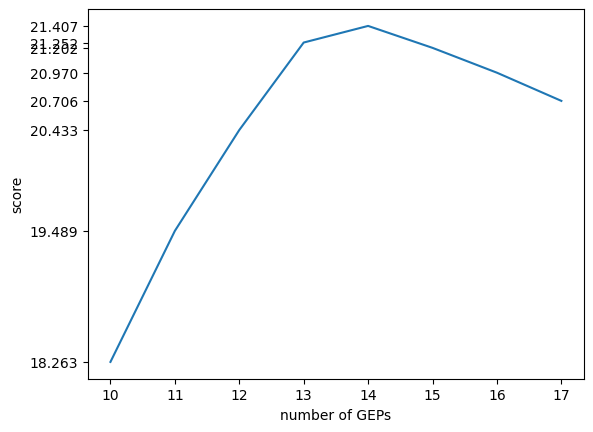

In [18]:
GEPs = range(10, 18)
plt.plot(GEPs,scores)
plt.yticks(scores)
plt.xlabel("number of GEPs")
plt.ylabel("score")
plt.show()

#### Run CorEx

Set parameters for CorEx run including the optimal number of GEPs found from the previous function

In [19]:
out = lc.Corex(n_hidden=14, verbose=True, gaussianize='standard', seed = 100)  # A Corex model with 14 factors

Linear CorEx with 14 latent factors


In [20]:
out.fit(adata_norm)

513 iterations to tol: 0.000010, TC=13.343093
46 iterations to tol: 0.000010, TC=21.034398
26 iterations to tol: 0.000010, TC=24.076949
9 iterations to tol: 0.000010, TC=25.208645
3 iterations to tol: 0.000010, TC=25.620840
1 iterations to tol: 0.000010, TC=25.769871
4 iterations to tol: 0.000010, TC=25.853933


#### Get CorEx outputs

CorEx outputs include mutual information (MI) for each gene in each GEP

In [21]:
mi = pd.DataFrame(data=out.moments['MI'],    # values
...              index=list(range(14)),    # 1st column as index
...              columns=adata_norm.columns)

We scale MI values across the genes

In [22]:
tMI = mi.T
scaler = MinMaxScaler()
nMI = scaler.fit_transform(tMI)
nMI = pd.DataFrame(nMI, columns = range(1,15))
nMI.index = tMI.index

Next, we calculate z-scores in the input matrix

In [23]:
mean = np.mean(adata_norm, axis=0)
std = np.sqrt(np.sum((adata_norm - mean)**2, axis=0) / 2000).clip(1e-10)
theta = (mean, std)
adata_normz = ((adata_norm - theta[0]) / theta[1])

The dotplot of scaled input matrix and a weight matrix (CorEx output) gives us the cell by GEP matrix. We can use it to visualize CorEx GEPs' expression in each cell

In [24]:
y = adata_normz.dot(out.ws.T)

### Find correlation between gene expression in ground truth and inferred GEPs

In [25]:
true_gep_means = geneparams.loc[:, [x for x in geneparams.columns if ('genemean' in x) and ('group' in x)]] ##leave only groupx_genemean columns

get mean expressions of genes in each GEP from geneparams dataframe and nor,alize them using variance from genestat dataset

In [26]:
true_gep_means.columns = [int(x.split('_')[0][5:]) for x in true_gep_means.columns] ##rename columns
true_gep_means = true_gep_means.T.astype(float) ##transpose
true_gep_means.loc[14, :] = geneparams.loc[true_gep_means.columns, 'prog_genemean'] ##add program column as 14
## Now load the genestats file and use that to filter in only included genes and divide by the inferred std-dev
true_gep_means_norm = true_gep_means.loc[:, genestats.index]
true_gep_means_norm = true_gep_means_norm.div(genestats.loc[:, 'var'] ** .5, axis=1)

In [27]:
true_gep_means_norm = true_gep_means_norm.loc[:, adata_norm.columns]

Find correlation between expression of genes in true GEPs and CorEx-inferred GEPs

In [28]:
def ColumnWiseCorrcoef(O, P):
    DO = O - O.mean(axis=0)
    DP = P - P.mean(axis=0)
    DO = DO / np.sqrt((DO**2).sum(axis=0))
    DP = DP / np.sqrt((DP**2).sum(axis=0))
    return np.dot(DO.T, DP)

def ColumnWiseCorrcoef_df(O, P):
    res=ColumnWiseCorrcoef(O.values, P.values)
    return(pd.DataFrame(res, index=O.columns, columns=P.columns))

Transpose the ground truth matrix and change GEPs names into TRUE_number

In [29]:
true_gep_means_norm = true_gep_means_norm.T
true_gep_means_norm.columns = 'TRUE_' + true_gep_means_norm.columns.astype(str)
true_gep_means_norm = true_gep_means_norm.rename(columns={'TRUE_14': 'ACTIVITY'})

Rename GEPs in mutual information matrix into CX_number

In [30]:
nMI.columns = 'CX_' + nMI.columns.astype(str)

Calculate correlation matrix

In [31]:
R_corr = ColumnWiseCorrcoef_df(true_gep_means_norm, nMI)

In [32]:
R_corr

,CX_1,CX_2,CX_3,CX_4,CX_5,CX_6,CX_7,CX_8,CX_9,CX_10,CX_11,CX_12,CX_13,CX_14
TRUE_1,-0.010808,-0.012549,-0.007486,-0.000790,0.001443,0.911369,0.006107,0.000610,0.017713,-0.001915,-0.000589,-0.005300,-0.003386,0.007943
TRUE_2,0.001365,-0.009056,-0.006971,-0.006439,-0.001658,-0.006381,0.858263,0.007398,0.018818,-0.002163,0.003750,0.001386,-0.002979,0.005634
TRUE_3,-0.010510,-0.012153,-0.006128,-0.005432,0.013010,0.002537,0.018623,0.878664,0.033796,-0.000750,0.000789,-0.003763,0.003885,0.011857
TRUE_4,-0.004737,-0.011260,-0.007208,-0.005664,0.007586,-0.005727,0.007093,-0.003523,0.873592,-0.000316,0.007464,0.001413,-0.001510,0.009752
TRUE_5,0.005884,0.005302,0.873553,-0.008046,-0.006632,-0.008125,0.011690,-0.007670,0.016325,-0.002116,-0.002328,0.004348,-0.005082,0.000042
TRUE_6,-0.009854,-0.010989,0.005729,0.011104,0.013181,-0.004711,0.026884,-0.003123,0.028195,0.001094,0.009910,0.847168,-0.002429,0.006230
TRUE_7,-0.002415,-0.011650,-0.009536,-0.003603,-0.004332,0.003865,0.012788,-0.005656,0.027039,0.005409,0.854520,-0.002943,-0.002587,0.005037
TRUE_8,-0.013597,0.902878,-0.002847,0.013774,-0.007350,-0.008957,0.004190,-0.008237,0.015599,-0.004127,-0.002564,-0.004622,-0.004822,-0.001196
TRUE_9,-0.010764,-0.012640,-0.009460,-0.005336,0.865979,-0.006000,0.014473,0.008347,0.045956,-0.002198,-0.000674,0.000920,-0.002016,0.001783
TRUE_10,-0.010989,0.000518,-0.008003,0.893433,-0.001686,-0.007367,0.006732,-0.006360,0.019905,0.001077,-0.000591,0.022565,-0.003620,0.001218


Visualize correlation

<Axes: >

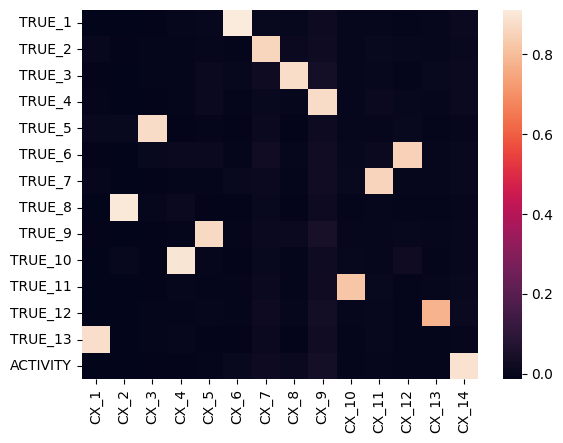

In [33]:
import seaborn as sns
sns.heatmap(R_corr)

Write the anndata object into a file

### Visually assess if CorEx-inferred GEPs match true cell types and the activity program

Add cell by GEPs data inferred from CorEx to the anndata object and visualize cells in UMAP plots

In [34]:
adata.obs = y

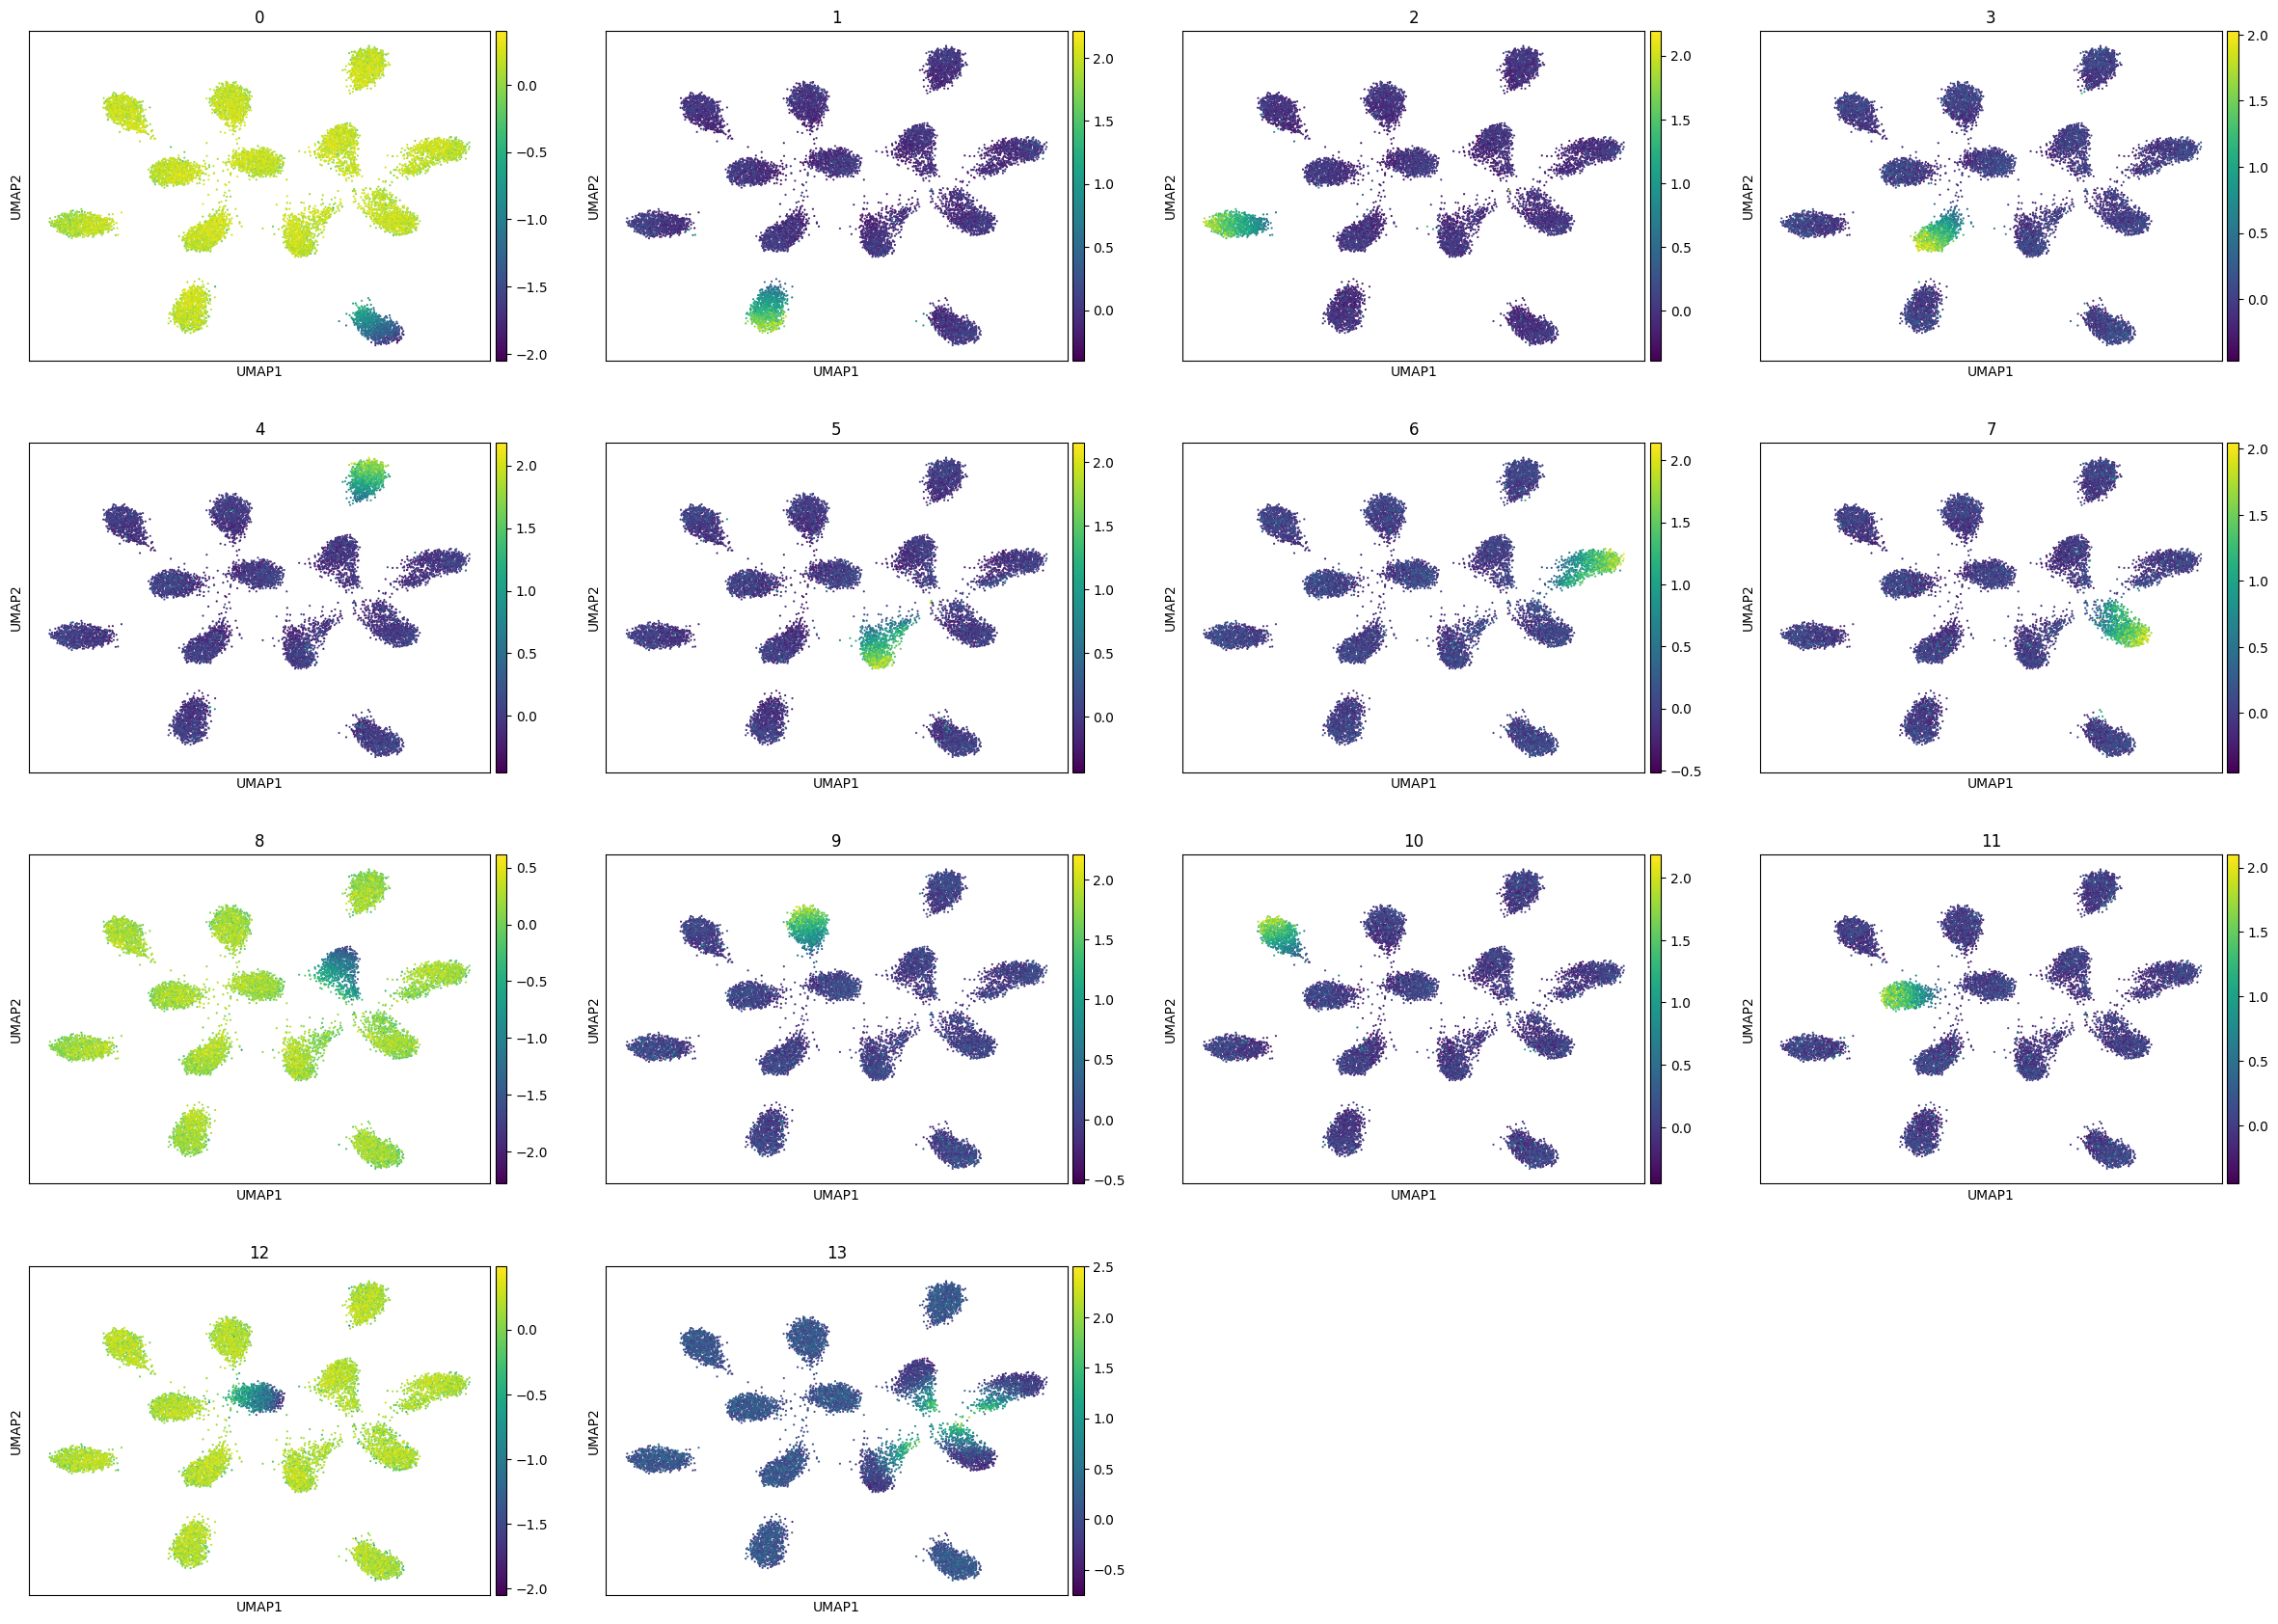

In [35]:
sc.pl.umap(adata, color = adata.obs)

In [36]:
import session_info
session_info.show()